In [1]:
import torch
import einops
from PIL import Image
from datasets import load_dataset
from pytorch_wavelets import DWTForward, DWTInverse 
from torchvision.transforms import ToPILImage, RandomCrop, PILToTensor

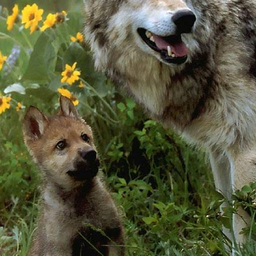

In [2]:
device="cuda:0"
train_dataset = load_dataset("danjacobellis/imagenet_hq", split="train")
valid_dataset = load_dataset("danjacobellis/imagenet_hq", split="validation")

def collate_fn(batch):
    return torch.cat([
        PILToTensor()(RandomCrop(256)(sample['image'])).unsqueeze(0) for sample in batch
    ])

dataloader_valid = torch.utils.data.DataLoader(
    valid_dataset.select([1,7,30,33]),
    batch_size=1,
    num_workers=12,
    drop_last=True,
    shuffle=False,
    collate_fn=collate_fn
)

valid_batch = next(iter(dataloader_valid))
valid_batch = valid_batch/255
valid_batch = valid_batch - 0.5
valid_batch = valid_batch.to(device)

for img in valid_batch:
    display(ToPILImage()(img+0.5))

In [3]:
dwt = DWTForward(J=1, mode='zero', wave='haar').to(device)
idwt = DWTInverse(mode='zero', wave='haar').to(device)
x = valid_batch.clone()
channels = x.shape[1]

In [4]:
def analysis_one_level(x):
    L, H = dwt(x)
    X = torch.cat([L.unsqueeze(2),H[0]],dim=2)
    X = einops.rearrange(X, 'b c f h w -> b (c f) h w')
    return X

def analysis(x,J=4):
    for _ in range(J):
        x = analysis_one_level(x)
    return x

def synthesis_one_level(X):
    X = einops.rearrange(X, 'b (c f) h w -> b c f h w', f=4)
    L, H = torch.split(X, [1, 3], dim=2)
    L = L.squeeze(2)
    H = [H]
    y = idwt((L, H))
    return y

def synthesis(x,J=4):
    for _ in range(J):
        x = synthesis_one_level(x)
    return x

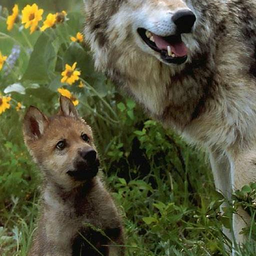

In [5]:
with torch.no_grad():
    X = analysis(x)
    y = synthesis(X)

display(ToPILImage()(y[0]+0.5))

In [6]:
X.shape

torch.Size([1, 768, 16, 16])